In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pqcd

from cmcrameri import cm
from scipy.interpolate import interp1d
from pqcd.utils import (
    rcparams, 
    to_GeV_per_cubic_femtometre,
    to_nucleons_per_cubic_femtometre,
    GeV_per_cubic_femtometer_to_dyn_per_square_cm,
    nsat
    )
plt.rcParams.update(rcparams)

### Default GP

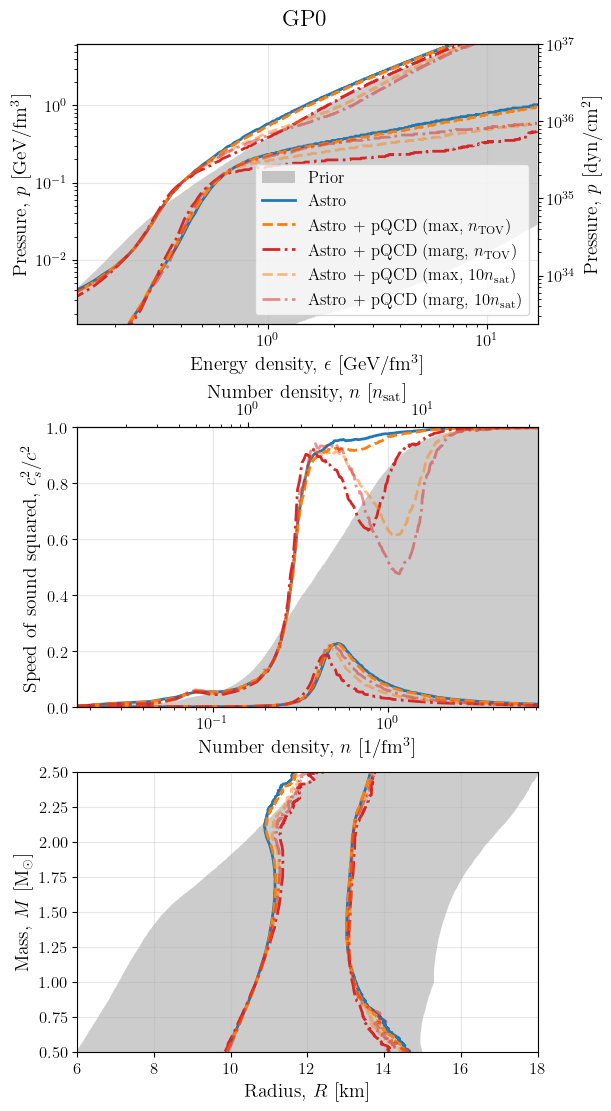

In [5]:
fig, axs = plt.subplots(3, 1, figsize=(6, 11), layout='constrained')

for ax in axs:
    ax.set_axisbelow(True)
    ax.grid(alpha=0.3)

axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[1].set_xscale('log')

x_pe = to_GeV_per_cubic_femtometre(np.linspace(5e13, 3e16, 1000))
x_cn = to_nucleons_per_cubic_femtometre(np.linspace(2.8e13, 1.5e16, 1000))
y_mr = np.linspace(0.5, 2.5, 1000)

# Prior
# -----

prior_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv('../data/eos-draws-default/quantiles/p_of_eps_quantiles_prior.csv')
)

axs[0].fill_between(
    x_pe,
    prior_quantiles_pe.loc[5,:].values,
    prior_quantiles_pe.loc[95,:].values,
    color='k',
    alpha=0.2,
    linewidth=0,
    label='Prior',
    zorder=0.1
)

# ---

astro_quantiles_cn = pd.read_csv(
    '../data/eos-draws-default/quantiles/cs2_of_rho_quantiles_prior.csv'
)

axs[1].fill_between(
    x_cn,
    astro_quantiles_cn.loc[5,:].values,
    astro_quantiles_cn.loc[95,:].values,
    color='k',
    alpha=0.2,
    linewidth=0,
    label='Prior',
    zorder=0.1
)

# ---

astro_quantiles_mr = pd.read_csv(
    '../data/eos-draws-default/quantiles/r_of_m_quantiles_prior.csv'
)

ax.fill_betweenx(
    y_mr, 
    astro_quantiles_mr.loc[5,:].values, 
    astro_quantiles_mr.loc[95,:].values, 
    color='k',
    alpha=0.2,
    linewidth=0,
    label='Prior',
    zorder=0.1
)

# Astro-only
# ----------

lw = 2

astro_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv('../data/eos-draws-default/quantiles/p_of_eps_quantiles_astro.csv')
)

axs[0].plot(
    x_pe, 
    astro_quantiles_pe.loc[5,:].values, 
    color='C0', 
    lw=lw,
    label='Astro'
)
axs[0].plot(x_pe, astro_quantiles_pe.loc[95,:].values, color='C0', lw=lw)

# ---

astro_quantiles_cn = pd.read_csv(
    '../data/eos-draws-default/quantiles/cs2_of_rho_quantiles_astro.csv'
)

axs[1].plot(
    x_cn, 
    astro_quantiles_cn.loc[5,:].values, 
    color='C0', 
    lw=lw,
    label='Astro'
)
axs[1].plot(x_cn, astro_quantiles_cn.loc[95,:].values, color='C0', lw=lw)

# --- 

astro_quantiles_mr = pd.read_csv(
    '../data/eos-draws-default/quantiles/r_of_m_quantiles_astro.csv'
)

axs[2].plot(
    astro_quantiles_mr.loc[5,:].values, 
    y_mr,
    color='C0', 
    lw=lw,
    label='Astro'
)
axs[2].plot(astro_quantiles_mr.loc[95,:].values, y_mr, color='C0', lw=lw)

# Max pQCD, nTOV, Xmarg
# ---------------------

pqcd_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv('../data/eos-draws-default/quantiles/p_of_eps_quantiles_astro_pqcd_ntov_Xmarg_mu2.6.csv')
)

axs[0].plot(
    x_pe, 
    pqcd_quantiles_pe.loc[5,:].values, 
    color='C1', 
    linestyle='--',
    lw=lw,
    label='Astro + pQCD (max, $n_\mathrm{TOV}$)'
)
axs[0].plot(
    x_pe, 
    pqcd_quantiles_pe.loc[95,:].values, 
    color='C1', 
    linestyle='--',
    lw=lw
)

# ---

pqcd_quantiles_cn = pd.read_csv(
    '../data/eos-draws-default/quantiles/cs2_of_rho_quantiles_astro_pqcd_ntov_Xmarg_mu2.6.csv'
)

axs[1].plot(
    x_cn, 
    pqcd_quantiles_cn.loc[5,:].values, 
    color='C1', 
    linestyle='--',
    lw=lw,
    label='Astro + pQCD (max, $n_\mathrm{TOV}$)'
)
axs[1].plot(
    x_cn, 
    pqcd_quantiles_cn.loc[95,:].values, 
    color='C1', 
    linestyle='--',
    lw=lw
)

# ---

pqcd_quantiles_mr = pd.read_csv(
    '../data/eos-draws-default/quantiles/r_of_m_quantiles_astro_pqcd_ntov_Xmarg_mu2.6.csv'
)

axs[2].plot(
    pqcd_quantiles_mr.loc[5,:].values, 
    y_mr,
    color='C1', 
    linestyle='--',
    lw=lw,
    label='Astro + pQCD (max, $n_\mathrm{TOV}$)'
)
axs[2].plot(
    pqcd_quantiles_mr.loc[95,:].values, 
    y_mr,
    color='C1', 
    linestyle='--',
    lw=lw
)

# Marg pQCD, nTOV
# ---------------

pqcd_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv('../data/eos-draws-default/quantiles/p_of_eps_quantiles_astro_pqcd_ntov_marg.csv')
)

axs[0].plot(
    x_pe, 
    pqcd_quantiles_pe.loc[5,:].values, 
    color='C3', 
    linestyle='-.',
    lw=lw,
    label='Astro + pQCD (marg, $n_\mathrm{TOV}$)'
)
axs[0].plot(
    x_pe, 
    pqcd_quantiles_pe.loc[95,:].values, 
    color='C3', 
    linestyle='-.',
    lw=lw
)

# ---

pqcd_quantiles_cn = pd.read_csv(
    '../data/eos-draws-default/quantiles/cs2_of_rho_quantiles_astro_pqcd_ntov_marg.csv'
)

axs[1].plot(
    x_cn, 
    pqcd_quantiles_cn.loc[5,:].values, 
    color='C3', 
    linestyle='-.',
    lw=lw,
    label='Astro + pQCD (marg, $n_\mathrm{TOV}$)'
)
axs[1].plot(
    x_cn, 
    pqcd_quantiles_cn.loc[95,:].values, 
    color='C3', 
    linestyle='-.',
    lw=lw
)

# ---

pqcd_quantiles_mr = pd.read_csv(
    '../data/eos-draws-default/quantiles/r_of_m_quantiles_astro_pqcd_ntov_marg.csv'
)

axs[2].plot(
    pqcd_quantiles_mr.loc[5,:].values, 
    y_mr,
    color='C3', 
    linestyle='-.',
    lw=lw,
    label='Astro + pQCD (marg, $n_\mathrm{TOV}$)'
)
axs[2].plot(
    pqcd_quantiles_mr.loc[95,:].values, 
    y_mr,
    color='C3', 
    linestyle='-.',
    lw=lw
)

# Max pQCD, 10nsat, Xmarg
# -----------------------

pqcd_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv('../data/eos-draws-default/quantiles/p_of_eps_quantiles_astro_pqcd_10nsat_Xmarg_mu2.6.csv')
)

alpha = 0.5

axs[0].plot(
    x_pe, 
    pqcd_quantiles_pe.loc[5,:].values, 
    color='C1', 
    linestyle='--',
    lw=lw,
    label='Astro + pQCD (max, $10 n_\mathrm{sat}$)',
    alpha=alpha
)
axs[0].plot(
    x_pe, 
    pqcd_quantiles_pe.loc[95,:].values, 
    color='C1', 
    linestyle='--',
    lw=lw,
    alpha=alpha
)

# ---

pqcd_quantiles_cn = pd.read_csv(
    '../data/eos-draws-default/quantiles/cs2_of_rho_quantiles_astro_pqcd_10nsat_Xmarg_mu2.6.csv'
)

axs[1].plot(
    x_cn, 
    pqcd_quantiles_cn.loc[5,:].values, 
    color='C1', 
    linestyle='--',
    lw=lw,
    label='Astro + pQCD (max, $10 n_\mathrm{sat}$)',
    alpha=alpha
)
axs[1].plot(
    x_cn, 
    pqcd_quantiles_cn.loc[95,:].values, 
    color='C1', 
    linestyle='--',
    lw=lw,
    alpha=alpha
)

# ---

pqcd_quantiles_mr = pd.read_csv(
    '../data/eos-draws-default/quantiles/r_of_m_quantiles_astro_pqcd_10nsat_Xmarg_mu2.6.csv'
)

axs[2].plot(
    pqcd_quantiles_mr.loc[5,:].values, 
    y_mr,
    color='C1', 
    linestyle='--',
    lw=lw,
    label='Astro + pQCD (max, $10 n_\mathrm{sat}$)',
    alpha=alpha
)
axs[2].plot(
    pqcd_quantiles_mr.loc[95,:].values, 
    y_mr,
    color='C1', 
    linestyle='--',
    lw=lw,
    alpha=alpha
)

# Marg pQCD, 10nsat
# -----------------

pqcd_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv('../data/eos-draws-default/quantiles/p_of_eps_quantiles_astro_pqcd_10nsat_marg.csv')
)

axs[0].plot(
    x_pe, 
    pqcd_quantiles_pe.loc[5,:].values, 
    color='C3', 
    linestyle='-.',
    lw=lw,
    label='Astro + pQCD (marg, $10n_\mathrm{sat}$)',
    alpha=alpha
)
axs[0].plot(
    x_pe, 
    pqcd_quantiles_pe.loc[95,:].values, 
    color='C3', 
    linestyle='-.',
    lw=lw,
    alpha=alpha
)

# ---

pqcd_quantiles_cn = pd.read_csv(
    '../data/eos-draws-default/quantiles/cs2_of_rho_quantiles_astro_pqcd_10nsat_marg.csv'
)

axs[1].plot(
    x_cn, 
    pqcd_quantiles_cn.loc[5,:].values, 
    color='C3', 
    linestyle='-.',
    lw=lw,
    label='Astro + pQCD (marg, $10n_\mathrm{sat}$)',
    alpha=alpha
)
axs[1].plot(
    x_cn, 
    pqcd_quantiles_cn.loc[95,:].values, 
    color='C3', 
    linestyle='-.',
    lw=lw,
    alpha=alpha
)

# ---

pqcd_quantiles_mr = pd.read_csv(
    '../data/eos-draws-default/quantiles/r_of_m_quantiles_astro_pqcd_10nsat_marg.csv'
)

axs[2].plot(
    pqcd_quantiles_mr.loc[5,:].values,
    y_mr, 
    color='C3', 
    linestyle='-.',
    lw=lw,
    label='Astro + pQCD (marg, $10n_\mathrm{sat}$)',
    alpha=alpha
)
axs[2].plot(
    pqcd_quantiles_mr.loc[95,:].values, 
    y_mr,
    color='C3', 
    linestyle='-.',
    lw=lw,
    alpha=alpha
)

# ---

axs[0].legend(loc='lower right')

xlim_pe = (0.13471795348380078, 17.002209254489188)
ylim_pe = (0.0014798402249155988, 6.262273589369166)

# axs[0].set_xlim(xlim_pe[0], astro_x_pe[-1])
# axs[0].set_ylim(ylim_pe[0]/14, ylim_pe[1]/2)

axs[0].set_xlim(xlim_pe)
axs[0].set_ylim(ylim_pe)

# axs[1].set_xlim(astro_x_cn[0], astro_x_cn[-1])
axs[1].set_xlim((x_cn[0],7.20534255445628))
axs[1].set_ylim(0, 1)

axs[2].set_xlim([6,18])
axs[2].set_ylim([y_mr[0], y_mr[-1]])

twinx = axs[0].twinx()
twinx.set_yscale('log')
twinx.set_ylim(GeV_per_cubic_femtometer_to_dyn_per_square_cm(np.array(axs[0].get_ylim())))
twinx.set_ylabel(r'Pressure, $p\ [\mathrm{dyn}/\mathrm{cm}^2]$')

twiny = axs[1].twiny()
twiny.set_xscale('log')
twiny.set_xlim(np.array(axs[1].get_xlim())/nsat)
twiny.set_xlabel('Number density, $n$ [$n_\mathrm{sat}$]')

fig.suptitle('GP0')

axs[0].set_xlabel('Energy density, $\epsilon$ [GeV/fm$^3$]')
axs[0].set_ylabel('Pressure, $p$ [GeV/fm$^3$]')

axs[1].set_xlabel('Number density, $n$ [1/fm$^3$]')
axs[1].set_ylabel('Speed of sound squared, $c_s^2/c^2$')

axs[2].set_xlabel(r'Radius, $R$ [km]')
axs[2].set_ylabel(r'Mass, $M$ [M${}_\odot$]')

fig.savefig('figures/paper/astro_pqcd_gp0_posterior.pdf', bbox_inches='tight')

### GP1

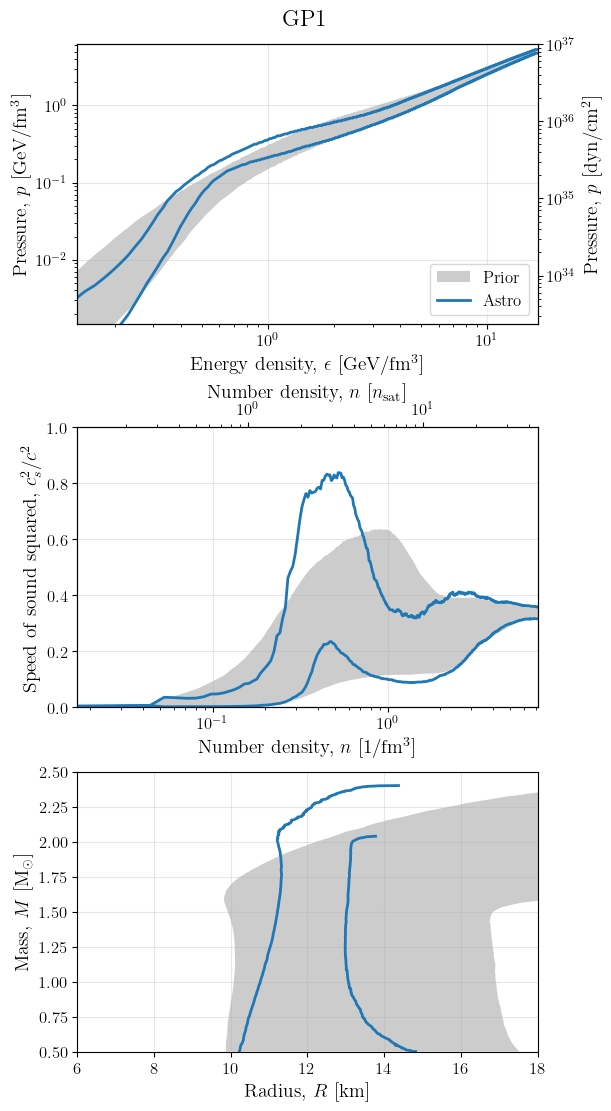

In [22]:
fig, axs = plt.subplots(3, 1, figsize=(6, 11), layout='constrained')

for ax in axs:
    ax.set_axisbelow(True)
    ax.grid(alpha=0.3)

axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[1].set_xscale('log')

x_pe = to_GeV_per_cubic_femtometre(np.linspace(5e13, 3e16, 1000))
x_cn = to_nucleons_per_cubic_femtometre(np.linspace(2.8e13, 1.5e16, 1000))
y_mr = np.linspace(0.5, 2.5, 1000)

# Prior
# -----

prior_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv('../data/eos-draws-modified/gp1/quantiles/p_of_eps_quantiles_prior.csv')
)

axs[0].fill_between(
    x_pe,
    prior_quantiles_pe.loc[5,:].values,
    prior_quantiles_pe.loc[95,:].values,
    color='k',
    alpha=0.2,
    linewidth=0,
    label='Prior',
    zorder=0.1
)

# ---

astro_quantiles_cn = pd.read_csv(
    '../data/eos-draws-modified/gp1/quantiles/cs2_of_rho_quantiles_prior.csv'
)

axs[1].fill_between(
    x_cn,
    astro_quantiles_cn.loc[5,:].values,
    astro_quantiles_cn.loc[95,:].values,
    color='k',
    alpha=0.2,
    linewidth=0,
    label='Prior',
    zorder=0.1
)

# ---

astro_quantiles_mr = np.loadtxt(
    '../data/eos-draws-modified/gp1/quantiles/r_of_m_quantiles_prior.dat'
)
astro_quantiles_mr[2][np.isnan(astro_quantiles_mr[2])] = 100

ax.fill_betweenx(
    y_mr, 
    astro_quantiles_mr[0], 
    astro_quantiles_mr[2], 
    color='k',
    alpha=0.2,
    linewidth=0,
    label='Prior',
    zorder=0.1
)

# Astro-only
# ----------

lw = 2

astro_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv('../data/eos-draws-modified/gp1/quantiles/p_of_eps_quantiles_astro.csv')
)

axs[0].plot(
    x_pe, 
    astro_quantiles_pe.loc[5,:].values, 
    color='C0', 
    lw=lw,
    label='Astro'
)
axs[0].plot(x_pe, astro_quantiles_pe.loc[95,:].values, color='C0', lw=lw)

# ---

astro_quantiles_cn = pd.read_csv(
    '../data/eos-draws-modified/gp1/quantiles/cs2_of_rho_quantiles_astro.csv'
)

axs[1].plot(
    x_cn, 
    astro_quantiles_cn.loc[5,:].values, 
    color='C0', 
    lw=lw,
    label='Astro'
)
axs[1].plot(x_cn, astro_quantiles_cn.loc[95,:].values, color='C0', lw=lw)

# --- 

astro_quantiles_mr = np.loadtxt(
    '../data/eos-draws-modified/gp1/quantiles/r_of_m_quantiles_astro.dat'
)

axs[2].plot(
    astro_quantiles_mr[0], 
    y_mr,
    color='C0', 
    lw=lw,
    label='Astro'
)
axs[2].plot(astro_quantiles_mr[2], y_mr, color='C0', lw=lw)

# ---

axs[0].legend(loc='lower right')

xlim_pe = (0.13471795348380078, 17.002209254489188)
ylim_pe = (0.0014798402249155988, 6.262273589369166)

# axs[0].set_xlim(xlim_pe[0], astro_x_pe[-1])
# axs[0].set_ylim(ylim_pe[0]/14, ylim_pe[1]/2)

axs[0].set_xlim(xlim_pe)
axs[0].set_ylim(ylim_pe)

# axs[1].set_xlim(astro_x_cn[0], astro_x_cn[-1])
axs[1].set_xlim((x_cn[0],7.20534255445628))
axs[1].set_ylim(0, 1)

axs[2].set_xlim([6,18])
axs[2].set_ylim([y_mr[0], y_mr[-1]])

twinx = axs[0].twinx()
twinx.set_yscale('log')
twinx.set_ylim(GeV_per_cubic_femtometer_to_dyn_per_square_cm(np.array(axs[0].get_ylim())))
twinx.set_ylabel(r'Pressure, $p\ [\mathrm{dyn}/\mathrm{cm}^2]$')

twiny = axs[1].twiny()
twiny.set_xscale('log')
twiny.set_xlim(np.array(axs[1].get_xlim())/nsat)
twiny.set_xlabel('Number density, $n$ [$n_\mathrm{sat}$]')

fig.suptitle('GP1')

axs[0].set_xlabel('Energy density, $\epsilon$ [GeV/fm$^3$]')
axs[0].set_ylabel('Pressure, $p$ [GeV/fm$^3$]')

axs[1].set_xlabel('Number density, $n$ [1/fm$^3$]')
axs[1].set_ylabel('Speed of sound squared, $c_s^2/c^2$')

axs[2].set_xlabel(r'Radius, $R$ [km]')
axs[2].set_ylabel(r'Mass, $M$ [M${}_\odot$]')

fig.savefig('figures/paper/astro_pqcd_gp1_posterior.pdf', bbox_inches='tight')

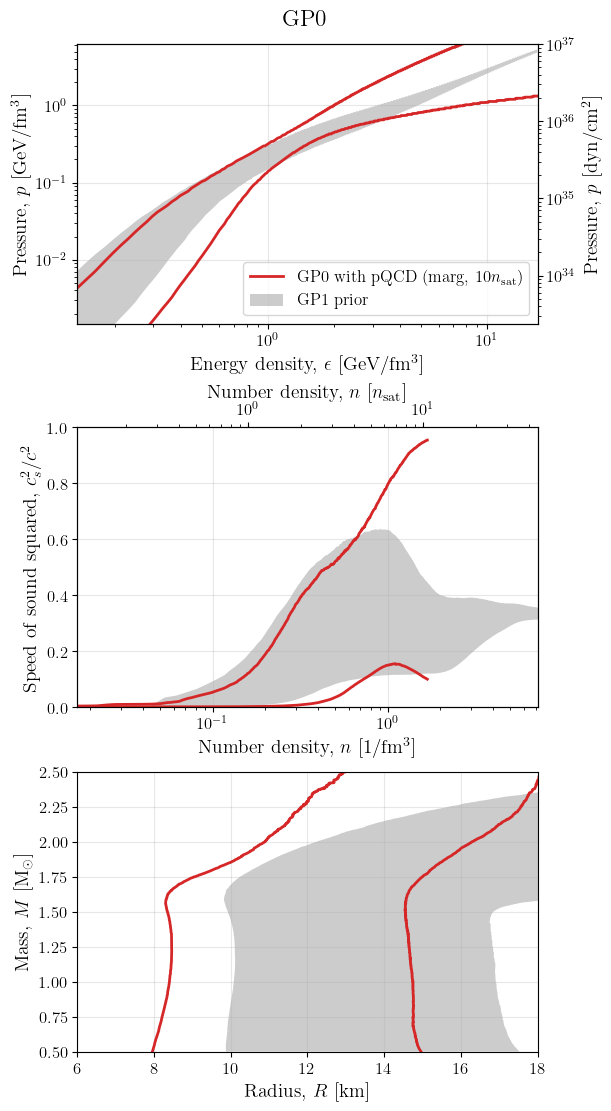

In [23]:
fig, axs = plt.subplots(3, 1, figsize=(6, 11), layout='constrained')

for ax in axs:
    ax.set_axisbelow(True)
    ax.grid(alpha=0.3)

axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[1].set_xscale('log')

x_pe = to_GeV_per_cubic_femtometre(np.linspace(5e13, 3e16, 1000))
x_cn = to_nucleons_per_cubic_femtometre(np.linspace(2.8e13, 1.5e16, 1000))
y_mr = np.linspace(0.5, 2.5, 1000)

# GP0 marg pQCD, 10nsat
# ---------------------

pqcd_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv('../data/eos-draws-default/quantiles/p_of_eps_quantiles_pqcd_10nsat_marg.csv')
)

axs[0].plot(
    x_pe, 
    pqcd_quantiles_pe.loc[5,:].values, 
    color='C3', 
    linestyle='-',
    lw=lw,
    label='GP0 with pQCD (marg, $10n_\mathrm{sat}$)'
)
axs[0].plot(
    x_pe, 
    pqcd_quantiles_pe.loc[95,:].values, 
    color='C3', 
    linestyle='-',
    lw=lw
)

# ---

pqcd_quantiles_cn = pd.read_csv(
    '../data/eos-draws-default/quantiles/cs2_of_rho_quantiles_pqcd_10nsat_marg.csv'
)

axs[1].plot(
    to_nucleons_per_cubic_femtometre(np.linspace(2.8e13, 2.8e15, 1000)), 
    pqcd_quantiles_cn.loc[5,:].values, 
    color='C3', 
    linestyle='-',
    lw=lw,
    label='GP0 with pQCD (marg, $10n_\mathrm{sat}$)'
)
axs[1].plot(
    to_nucleons_per_cubic_femtometre(np.linspace(2.8e13, 2.8e15, 1000)), 
    pqcd_quantiles_cn.loc[95,:].values, 
    color='C3', 
    linestyle='-',
    lw=lw
)

# ---

pqcd_quantiles_mr = pd.read_csv(
    '../data/eos-draws-default/quantiles/r_of_m_quantiles_pqcd_10nsat_marg.csv'
)

axs[2].plot(
    pqcd_quantiles_mr.loc[5,:].values, 
    y_mr,
    color='C3', 
    linestyle='-',
    lw=lw,
    label='GP0 with pQCD (marg, $10n_\mathrm{sat}$)'
)
axs[2].plot(
    pqcd_quantiles_mr.loc[95,:].values, 
    y_mr,
    color='C3', 
    linestyle='-',
    lw=lw
)

# GP1 prior
# ---------

prior_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv('../data/eos-draws-modified/gp1/quantiles/p_of_eps_quantiles_prior.csv')
)

axs[0].fill_between(
    x_pe,
    prior_quantiles_pe.loc[5,:].values,
    prior_quantiles_pe.loc[95,:].values,
    color='k',
    alpha=0.2,
    linewidth=0,
    label='GP1 prior',
    zorder=0.1
)

# ---

astro_quantiles_cn = pd.read_csv(
    '../data/eos-draws-modified/gp1/quantiles/cs2_of_rho_quantiles_prior.csv'
)

axs[1].fill_between(
    x_cn,
    astro_quantiles_cn.loc[5,:].values,
    astro_quantiles_cn.loc[95,:].values,
    color='k',
    alpha=0.2,
    linewidth=0,
    label='GP1 prior',
    zorder=0.1
)

# ---

astro_quantiles_mr = np.loadtxt(
    '../data/eos-draws-modified/gp1/quantiles/r_of_m_quantiles_prior.dat'
)
astro_quantiles_mr[2][np.isnan(astro_quantiles_mr[2])] = 100

ax.fill_betweenx(
    y_mr, 
    astro_quantiles_mr[0], 
    astro_quantiles_mr[2], 
    color='k',
    alpha=0.2,
    linewidth=0,
    label='Prior',
    zorder=0.1
)

# ---

axs[0].legend(loc='lower right')

xlim_pe = (0.13471795348380078, 17.002209254489188)
ylim_pe = (0.0014798402249155988, 6.262273589369166)

# axs[0].set_xlim(xlim_pe[0], astro_x_pe[-1])
# axs[0].set_ylim(ylim_pe[0]/14, ylim_pe[1]/2)

axs[0].set_xlim(xlim_pe)
axs[0].set_ylim(ylim_pe)

# axs[1].set_xlim(astro_x_cn[0], astro_x_cn[-1])
axs[1].set_xlim((x_cn[0],7.20534255445628))
axs[1].set_ylim(0, 1)

axs[2].set_xlim([6,18])
axs[2].set_ylim([y_mr[0], y_mr[-1]])

twinx = axs[0].twinx()
twinx.set_yscale('log')
twinx.set_ylim(GeV_per_cubic_femtometer_to_dyn_per_square_cm(np.array(axs[0].get_ylim())))
twinx.set_ylabel(r'Pressure, $p\ [\mathrm{dyn}/\mathrm{cm}^2]$')

twiny = axs[1].twiny()
twiny.set_xscale('log')
twiny.set_xlim(np.array(axs[1].get_xlim())/nsat)
twiny.set_xlabel('Number density, $n$ [$n_\mathrm{sat}$]')

fig.suptitle('GP0')

axs[0].set_xlabel('Energy density, $\epsilon$ [GeV/fm$^3$]')
axs[0].set_ylabel('Pressure, $p$ [GeV/fm$^3$]')

axs[1].set_xlabel('Number density, $n$ [1/fm$^3$]')
axs[1].set_ylabel('Speed of sound squared, $c_s^2/c^2$')

axs[2].set_xlabel(r'Radius, $R$ [km]')
axs[2].set_ylabel(r'Mass, $M$ [M${}_\odot$]')

fig.savefig('figures/paper/pqcd_gp0_gp1_comparison.pdf', bbox_inches='tight')

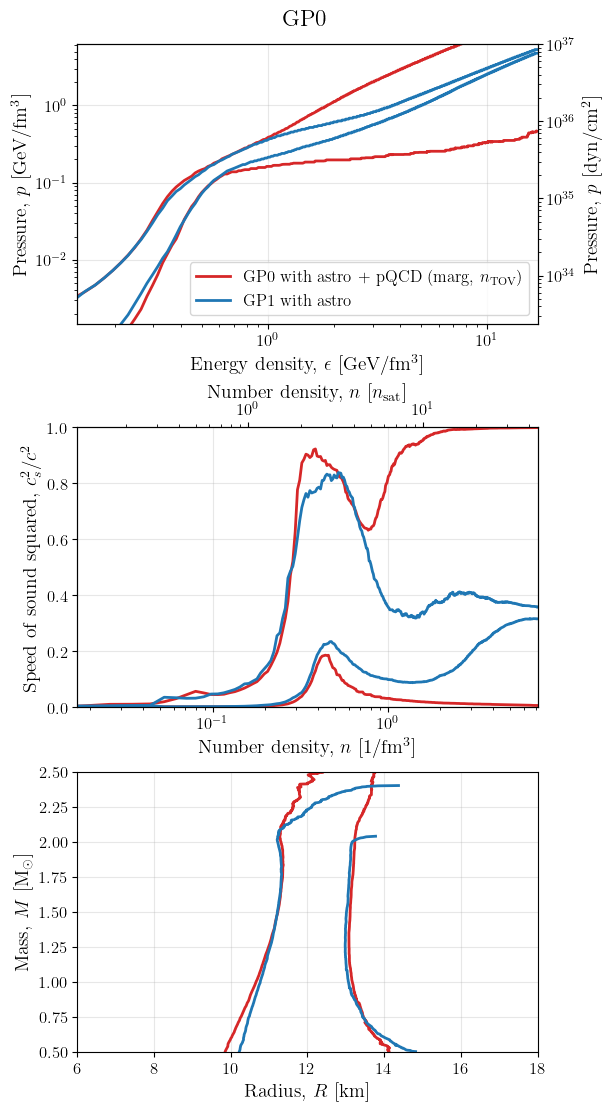

In [24]:
fig, axs = plt.subplots(3, 1, figsize=(6, 11), layout='constrained')

for ax in axs:
    ax.set_axisbelow(True)
    ax.grid(alpha=0.3)

axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[1].set_xscale('log')

x_pe = to_GeV_per_cubic_femtometre(np.linspace(5e13, 3e16, 1000))
x_cn = to_nucleons_per_cubic_femtometre(np.linspace(2.8e13, 1.5e16, 1000))
y_mr = np.linspace(0.5, 2.5, 1000)

# GP0 astro + marg pQCD, nTOV
# ---------------------------

pqcd_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv('../data/eos-draws-default/quantiles/p_of_eps_quantiles_astro_pqcd_ntov_marg.csv')
)

axs[0].plot(
    x_pe, 
    pqcd_quantiles_pe.loc[5,:].values, 
    color='C3', 
    linestyle='-',
    lw=lw,
    label='GP0 with astro + pQCD (marg, $n_\mathrm{TOV}$)'
)
axs[0].plot(
    x_pe, 
    pqcd_quantiles_pe.loc[95,:].values, 
    color='C3', 
    linestyle='-',
    lw=lw
)

# ---

pqcd_quantiles_cn = pd.read_csv(
    '../data/eos-draws-default/quantiles/cs2_of_rho_quantiles_astro_pqcd_ntov_marg.csv'
)

axs[1].plot(
    x_cn,
    pqcd_quantiles_cn.loc[5,:].values, 
    color='C3', 
    linestyle='-',
    lw=lw,
    label='GP0 with astro + pQCD (marg, $n_\mathrm{TOV}$)'
)
axs[1].plot(
    x_cn, 
    pqcd_quantiles_cn.loc[95,:].values, 
    color='C3', 
    linestyle='-',
    lw=lw
)

# ---

pqcd_quantiles_mr = pd.read_csv(
    '../data/eos-draws-default/quantiles/r_of_m_quantiles_astro_pqcd_ntov_marg.csv'
)

axs[2].plot(
    pqcd_quantiles_mr.loc[5,:].values, 
    y_mr,
    color='C3', 
    linestyle='-',
    lw=lw,
    label='GP0 with astro + pQCD (marg, $n_\mathrm{TOV}$)'
)
axs[2].plot(
    pqcd_quantiles_mr.loc[95,:].values, 
    y_mr,
    color='C3', 
    linestyle='-',
    lw=lw
)

# GP1 with astro
# --------------

lw = 2

astro_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv('../data/eos-draws-modified/gp1/quantiles/p_of_eps_quantiles_astro.csv')
)

axs[0].plot(
    x_pe, 
    astro_quantiles_pe.loc[5,:].values, 
    color='C0', 
    lw=lw,
    label='GP1 with astro'
)
axs[0].plot(x_pe, astro_quantiles_pe.loc[95,:].values, color='C0', lw=lw)

# ---

astro_quantiles_cn = pd.read_csv(
    '../data/eos-draws-modified/gp1/quantiles/cs2_of_rho_quantiles_astro.csv'
)

axs[1].plot(
    x_cn, 
    astro_quantiles_cn.loc[5,:].values, 
    color='C0', 
    lw=lw,
    label='GP1 with astro'
)
axs[1].plot(x_cn, astro_quantiles_cn.loc[95,:].values, color='C0', lw=lw)

# --- 

astro_quantiles_mr = np.loadtxt(
    '../data/eos-draws-modified/gp1/quantiles/r_of_m_quantiles_astro.dat'
)

axs[2].plot(
    astro_quantiles_mr[0], 
    y_mr,
    color='C0', 
    lw=lw,
    label='Astro'
)
axs[2].plot(astro_quantiles_mr[2], y_mr, color='C0', lw=lw)

# ---

axs[0].legend(loc='lower right')

xlim_pe = (0.13471795348380078, 17.002209254489188)
ylim_pe = (0.0014798402249155988, 6.262273589369166)

# axs[0].set_xlim(xlim_pe[0], astro_x_pe[-1])
# axs[0].set_ylim(ylim_pe[0]/14, ylim_pe[1]/2)

axs[0].set_xlim(xlim_pe)
axs[0].set_ylim(ylim_pe)

# axs[1].set_xlim(astro_x_cn[0], astro_x_cn[-1])
axs[1].set_xlim((x_cn[0],7.20534255445628))
axs[1].set_ylim(0, 1)

axs[2].set_xlim([6,18])
axs[2].set_ylim([y_mr[0], y_mr[-1]])

twinx = axs[0].twinx()
twinx.set_yscale('log')
twinx.set_ylim(GeV_per_cubic_femtometer_to_dyn_per_square_cm(np.array(axs[0].get_ylim())))
twinx.set_ylabel(r'Pressure, $p\ [\mathrm{dyn}/\mathrm{cm}^2]$')

twiny = axs[1].twiny()
twiny.set_xscale('log')
twiny.set_xlim(np.array(axs[1].get_xlim())/nsat)
twiny.set_xlabel('Number density, $n$ [$n_\mathrm{sat}$]')

fig.suptitle('GP0')

axs[0].set_xlabel('Energy density, $\epsilon$ [GeV/fm$^3$]')
axs[0].set_ylabel('Pressure, $p$ [GeV/fm$^3$]')

axs[1].set_xlabel('Number density, $n$ [1/fm$^3$]')
axs[1].set_ylabel('Speed of sound squared, $c_s^2/c^2$')

axs[2].set_xlabel(r'Radius, $R$ [km]')
axs[2].set_ylabel(r'Mass, $M$ [M${}_\odot$]')

fig.savefig('figures/paper/astro_pqcd_gp0_gp1_comparison.pdf', bbox_inches='tight')

### GP2

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(13, 4))

fig.subplots_adjust(wspace=0.4)
for ax in axs:
    ax.set_axisbelow(True)
    ax.grid(alpha=0.3)

axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[1].set_xscale('log')

# Prior
# -----

prior_x_pe = to_GeV_per_cubic_femtometre(np.linspace(3e13, 2e16, 1000))
prior_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv(f'../data/eos-draws-modified/24/quantiles/p_of_eps_prior_quantiles.csv')
)

axs[0].fill_between(
    prior_x_pe,
    prior_quantiles_pe.loc[5,:].values,
    prior_quantiles_pe.loc[95,:].values,
    color='k',
    alpha=0.2,
    linewidth=0,
    label='Prior',
    zorder=0.1
)

# ---

prior_x_cn = to_nucleons_per_cubic_femtometre(np.linspace(2.8e13, 2.8e15, 1000))
astro_quantiles_cn = pd.read_csv(f'../data/eos-draws-modified/24/quantiles/cs2_of_rho_prior_quantiles.csv')

axs[1].fill_between(
    prior_x_cn,
    astro_quantiles_cn.loc[5,:].values,
    astro_quantiles_cn.loc[95,:].values,
    color='k',
    alpha=0.2,
    linewidth=0,
    label='Prior',
    zorder=0.1
)

# Astro-only
# ----------

lw = 2

astro_x_pe = to_GeV_per_cubic_femtometre(np.linspace(3e13, 2e16, 1000))
astro_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv(f'../data/eos-draws-modified/24/quantiles/p_of_eps_astro_quantiles.csv')
)

axs[0].plot(
    astro_x_pe, 
    astro_quantiles_pe.loc[5,:].values, 
    color='C0', 
    lw=lw,
    label='Astro'
)
axs[0].plot(astro_x_pe, astro_quantiles_pe.loc[95,:].values, color='C0', lw=lw)

# ---

astro_x_cn = to_nucleons_per_cubic_femtometre(np.linspace(2.8e13, 2.8e15, 1000))
astro_quantiles_cn = pd.read_csv(f'../data/eos-draws-modified/24/quantiles/cs2_of_rho_astro_quantiles.csv')

axs[1].plot(
    astro_x_cn, 
    astro_quantiles_cn.loc[5,:].values, 
    color='C0', 
    lw=lw,
    label='Astro'
)
axs[1].plot(astro_x_cn, astro_quantiles_cn.loc[95,:].values, color='C0', lw=lw)

# ---

axs[0].legend(loc='lower right')

xlim_pe = (0.13471795348380078, 17.002209254489188)
ylim_pe = (0.0014798402249155988, 6.262273589369166)

axs[0].set_xlim(xlim_pe[0], astro_x_pe[-1])
axs[0].set_ylim(ylim_pe[0]/14, ylim_pe[1]/2)

axs[1].set_xlim(astro_x_cn[0], astro_x_cn[-1])
axs[1].set_ylim(0, 1)

twinx = axs[0].twinx()
twinx.set_yscale('log')
twinx.set_ylim(GeV_per_cubic_femtometer_to_dyn_per_square_cm(np.array(axs[0].get_ylim())))
twinx.set_ylabel(r'Pressure, $p\ [\mathrm{dyn}/\mathrm{cm}^2]$')

twiny = axs[1].twiny()
twiny.set_xscale('log')
twiny.set_xlim(np.array(axs[1].get_xlim())/nsat)
twiny.set_xlabel('Number density, $n$ [$n_\mathrm{sat}$]')

fig.suptitle('GP2')

axs[0].set_xlabel('Energy density, $\epsilon$ [GeV/fm$^3$]')
axs[0].set_ylabel('Pressure, $p$ [GeV/fm$^3$]')

axs[1].set_xlabel('Number density, $n$ [1/fm$^3$]')
axs[1].set_ylabel('Speed of sound squared, $c_s^2/c^2$');

In [ ]:
collated_eos = pd.read_csv('../data/eos-draws-modified/eos-draws-modified-24.csv', index_col=0)

In [ ]:
min_pressure = to_GeV_per_cubic_femtometre(1e10)
max_pressure = to_GeV_per_cubic_femtometre(1e16)

fig, ax = plt.subplots()
ax.set_xscale('log')

for eos_number, weights in collated_eos.iterrows():

    eos = pd.read_csv(
        '../data/eos-draws-modified/24/margagn/'
        f'DRAWmod1000-{eos_number//1000:06}/eos-draw-{int(eos_number):06}.csv'
    )

    pressure = to_GeV_per_cubic_femtometre(eos.pressurec2)
    energy_density = to_GeV_per_cubic_femtometre(eos.energy_densityc2)
    number_density = to_nucleons_per_cubic_femtometre(eos.baryon_density)

    chemical_potential = (energy_density+pressure)/number_density
    speed_of_sound_squared = np.gradient(pressure, energy_density)

    if weights.logweight_total < 0:
        c = 'C3'
        alpha = 0.
        zorder = 2
        lw = 1
    else:
        c = 'C0'
        alpha = 0.2
        zorder = 1
        lw = 2

    ax.plot(pressure, speed_of_sound_squared, c=c, alpha=alpha, zorder=zorder, lw=lw)

ax.set_xlim(min_pressure, max_pressure)
ax.set_ylim(0,1)

ax.set_xlabel(r'Pressure, $p$ [GeV/fm$^3$]')
ax.set_ylabel(r'Speed of sound squared, $c_s^2$');

In [ ]:
len(collated_eos)

In [ ]:
CET_values = {
    'soft': [0.966, 0.176, 2.163/1000],
    'stiff': [0.978, 0.176, 3.542/1000]
}

muL, nL, pL = CET_values['soft']
epsilonL = pqcd.epsilon_func(muL, nL, pL)

X = 2
muH = 2.6
pQCDX = pqcd.pQCD(X)
nH, pH = pQCDX.nH(muH), pQCDX.pH(muH)
epsilonH = pqcd.epsilon_func(muH, nH, pH)

constraints = pqcd.constraints(muL, nL, pL, muH, nH, pH)
mu_array = np.linspace(muL, muH, 1000)

In [ ]:
min_pressure = to_GeV_per_cubic_femtometre(1e10)
max_pressure = to_GeV_per_cubic_femtometre(1e16)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[1].set_xscale('log')

# Theory predictions

axs[0].plot(constraints.muL, constraints.nL, 'o', c='C4', zorder=11, clip_on=False)
axs[0].plot(constraints.muH, constraints.nH, 'o', c='C5', zorder=11, clip_on=False)

ylim = [0, axs[0].get_ylim()[1]]

# Constraints

axs[0].fill_between(mu_array, constraints.nmin(mu_array), ylim[0], color='k', alpha=0.2, lw=0)
axs[0].fill_between(mu_array, constraints.nmax(mu_array), ylim[1], color='k', alpha=0.2, lw=0)

axs[0].plot(mu_array, constraints.nmin(mu_array), c='k', ls='--', alpha=0.5, zorder=10)
axs[0].plot(mu_array, constraints.nmax(mu_array), c='k', ls='--', alpha=0.5, zorder=10)

for eos_number in range(4000,20000):

    eos = pd.read_csv(
        '../data/eos-draws-modified/25/margagn/'
        f'DRAWmod1000-{eos_number//1000:06}/eos-draw-{int(eos_number):06}.csv'
    )

    pressure = to_GeV_per_cubic_femtometre(eos.pressurec2)
    energy_density = to_GeV_per_cubic_femtometre(eos.energy_densityc2)
    number_density = to_nucleons_per_cubic_femtometre(eos.baryon_density)

    chemical_potential = (energy_density+pressure)/number_density
    speed_of_sound_squared = np.gradient(pressure, energy_density)

    axs[0].plot(
        chemical_potential,
        number_density,
        c='C0',
        alpha=0.01,
        zorder=0.5
        )
    
    axs[1].plot(
        pressure,
        speed_of_sound_squared,
        c='C0',
        alpha=0.01,
        zorder=0.5
        )

axs[0].set_xlim(constraints.muL, constraints.muH)
axs[0].set_ylim(ylim)

axs[1].set_xlim(min_pressure, max_pressure)
axs[1].set_ylim(0, 1)

axs[0].set_xlabel(r'$\mu$ [GeV]')
axs[0].set_ylabel(r'$n$ [1/fm$^3$]')

axs[1].set_xlabel(r'$p$ [GeV/fm$^3$]')
axs[1].set_ylabel(r'$c_s^2$');